# Visualizing Pollution-Related Public Health Disparities in New York City
## Nick Sawhney

<img src=https://nicksawhney.github.io/NYCAirMaps/thumbnail.png width="40%" align = "right">

### Overview:
Every New Yorker has had a day where the city air just didn't agree with them. Though air pollution in New York has steadily been getting better over the years, it still is impacting the health of many across the city. I wanted to analyze the sources of air pollution within the city and the disparity between sources and effects. I use the Air Quality dataset from [**NYC Open Data**](https://opendata.cityofnewyork.us/) to visualize the disparities between pollution sources and their health effects. I'll be using the data analysis library `pandas` for the air quality data, and `geopandas` for geographic data analysis. For visualization, I'll be using `matplotlib` for static maps and `folium` for interactive maps. I found that the areas that produce the most pollution are among the least affected by it from a public health standpoint. 


<br><br>

### Formatting the Data
I'm using the Department of Health and Mental Hygeine's Air Quality dataset from NYC Open Data. Let's import the libraries we need and take a look.

In [16]:
import pandas as pd
import geopandas as gpd
import folium
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [17]:
air_data = pd.read_csv('Air_Quality.csv', encoding='latin1')
air_data.head()

indicator_data_id  indicator_id  \
0             130728           646   
1             130729           646   
2             130730           646   
3             130731           646   
4             130732           646   

                                                name                Measure  \
0  Air Toxics Concentrations- Average Benzene Con...  Average Concentration   
1  Air Toxics Concentrations- Average Benzene Con...  Average Concentration   
2  Air Toxics Concentrations- Average Benzene Con...  Average Concentration   
3  Air Toxics Concentrations- Average Benzene Con...  Average Concentration   
4  Air Toxics Concentrations- Average Benzene Con...  Average Concentration   

  geo_type_name  geo_entity_id geo_entity_name year_description  \
0       Borough              1           Bronx             2005   
1       Borough              2        Brooklyn             2005   
2       Borough              3       Manhattan             2005   
3       Borough              4          Queens             2005   
4       Borough              5   Staten Island             2005   

   data_valuemessage  
0                2.8  
1                2.8  
2                4.7  
3                1.9  
4                1.6

This dataset is composed of a name, measurement type, year/time period, and region for each recorded measurement. There are some measurements representing pollutant levels in NYC air, and others representing hospitalizations and deaths attributable to certain pollutants. I want to make sure that I'm only working with neighborhood-level data, so I create a column that combines all the details of the measurement into one description. That way, I can have a unique column for each measurement in each region. I also remove Boroguh and Citywide data from the set because we only care about neighborhood-level data for this experiement, and I remove hospitalization data from 2005-2007, since our average pollutant measurements are all from after that time period.

In [18]:
air_data = air_data[~air_data['name'].str.startswith('Traffic Density')]

air_data = air_data[~air_data['year_description'].str.contains('2005-2007')]

air_data = air_data[air_data['geo_type_name'] == 'UHF42'].reset_index()
air_data['pollutant'] = (air_data['name'] 
                         + ' ' + air_data['year_description'] 
                         + ' ' + air_data['Measure']).str\
                        .replace(',', '')\
                        .replace('-', '')\
                        .replace(' ', '_')\

Next, I'm going to import the geographic data I need to create the maps. I'm using GIS data provided by NYC Department of Health which shows each "United Health Fund" neighborhood's boundaries, which is the most granular regional designation in the Air Quality dataset.

I clean the first row in order to help with pandas down the line, and I group the Air Quality dataset by region.  From this, I discovered there were some small differences in how certain neighborhoods were written down (e.g. 'Crotona -Tremont' vs 'Crotona - Tremont’). I used Python's dictionary comprehensions and a pandas method to fix it. I also group the pollutant types for use later. Finally, I merge the datasets based on the neighborhood. 

In [19]:
neighborhoods = gpd.read_file('UHF_42_DOHMH_2009').dropna()
neighborhoods['UHF_NEIGH'][0] ='None'
neighborhoods = neighborhoods.set_index('UHF_NEIGH')
neighborhood_groups = air_data.groupby('geo_entity_name').groups

air_data = air_data.replace(
    {x: y for x, y in zip(
        sorted(list(neighborhood_groups.keys())), 
        sorted(list(neighborhoods.index))) if x!=y})

pollutant_groups = air_data.groupby('pollutant').groups
pollutants = [group for group in pollutant_groups]

for group in pollutant_groups:
    neighborhoods = pd.concat(
        [neighborhoods, 
         air_data.loc[pollutant_groups[group]]
                 .drop('index', axis=1)
                 .drop_duplicates()
                 .set_index('geo_entity_name')['data_valuemessage']], 
                    axis = 1, 
                    join_axes = [neighborhoods.index])\
        .rename({'data_valuemessage': group}, axis=1)
    
neighborhoods = neighborhoods.reset_index()  
neighborhoods.head()

UHF_NEIGH  OBJECTID  UHFCODE     SHAPE_Leng    SHAPE_Area  \
0  Kingsbridge - Riverdale         2    101.0   57699.154353  1.332914e+08   
1          Northeast Bronx         3    102.0   88219.319109  1.813708e+08   
2     Fordham - Bronx Park         4    103.0   59711.871991  1.407724e+08   
3     Pelham - Throgs Neck         5    104.0  250903.372273  3.865737e+08   
4        Crotona - Tremont         6    105.0   66676.089072  1.068978e+08   

  BOROUGH                                           geometry  \
0   Bronx  POLYGON ((1017992.893460184 269222.9642282724,...   
1   Bronx  POLYGON ((1025012.990312353 270794.260298267, ...   
2   Bronx  POLYGON ((1023994.479554102 261065.9674189389,...   
3   Bronx  (POLYGON ((1017075.038996696 237316.1822414398...   
4   Bronx  POLYGON ((1007916.255148947 252530.7522059381,...   

   Air Toxics Concentrations- Average Benzene Concentrations 2005 Average Concentration  \
0                                                2.9                                      
1                                                2.8                                      
2                                                2.7                                      
3                                                2.7                                      
4                                                3.0                                      

   Air Toxics Concentrations- Average Formaldehyde Concentrations 2005 Average Concentration  \
0                                                3.2                                           
1                                                3.2                                           
2                                                3.2                                           
3                                                3.2                                           
4                                                3.4                                           

   Boiler Emissions- Total NOx Emissions 2013 Per km2  ...  \
0                                               42.5   ...   
1                                               33.8   ...   
2                                               71.0   ...   
3                                               24.9   ...   
4                                               62.5   ...   

   O3-Attributable Asthma ED Visits 2009-2011 Rate- 18 Yrs and Older  \
0                                               26.5                   
1                                               42.2                   
2                                               73.6                   
3                                               58.1                   
4                                              127.4                   

   O3-Attributable Asthma ED Visits 2009-2011 Rate- Children 0 to 17 Yrs Old  \
0                                               66.2                           
1                                               79.3                           
2                                              125.0                           
3                                              116.0                           
4                                              183.9                           

   O3-Attributable Asthma Hospitalizations  2009-2011 Rate- 18 Yrs and Older  \
0                                                7.5                           
1                                                9.8                           
2                                               14.4                           
3                                               11.7                           
4                                               18.9                           

   O3-Attributable Asthma Hospitalizations  2009-2011 Rate- Children 0 to 17 Yrs Old  \
0                                               22.3                                   
1                                               32.2                                   
2      

The final dataset should have everything we need to start exploring! As you can see, for each neighborhood we have geographic location and geometry data, as well as measurements for each pollutant. Now we can get to the fun part.

### Lets Make Some Maps!

Thanks to geopandas, I can treat geographic data like any other dataframe, so it's relatively simple to plot maps of all pollutants and health impacts. I also tried to make them as colorblind-friendly as possible. I inverted the color of Ozone Concentration because unlike other pollutants, it is the *lack of* Ozone that causes negative health impacts. Every map is shown below, and I'll be going into some interesting findings next!
    
Keep in mind, the colors you see on each map are **all scaled differently** because the indicators all have different impacts, i.e. a "high" concentration of Carbon Dioxide is different than a "high" concentration of Nitric Oxide. 

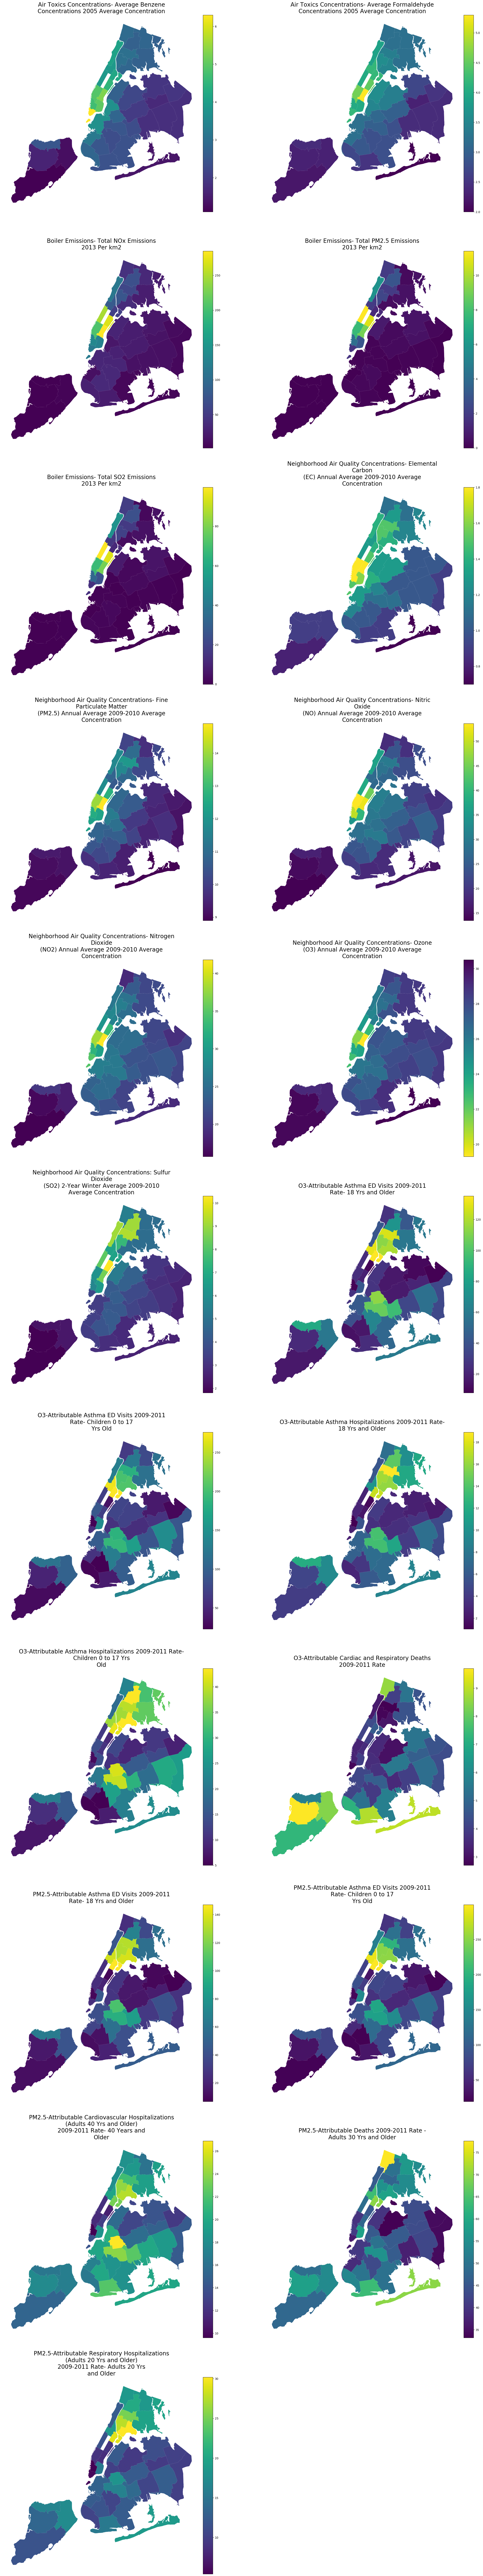

In [20]:
from helpers import split_title_line

#Plotting the maps
plt.rcParams['axes.titlesize'] = 20
fig, axs = plt.subplots(nrows=11, ncols=2, figsize=(30, 165), dpi=100)
for axis, pollutant in enumerate(pollutants):
    row = axis // 2
    col = axis % 2
    cm = 'viridis'
    if('Ozone' in pollutant and 'Concentration' in pollutant):
        cm = 'viridis_r'
    divider = make_axes_locatable(axs[row][col])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    axs[row][col] = neighborhoods.plot(ax=axs[row][col], cmap = cm, column = pollutant, legend = True, cax=cax)
    axs[row][col].set_title(split_title_line(pollutant, max_words = 5))
    axs[row][col].axis('off')

axs[-1][-1].axis('off')
plt.savefig('figs/master.png')
plt.show()

There's quite a bit of very interesting data here! It makes a lot of sense that the highest concentration of pollutant output or Ozone depletion is located in or around middle and lower Manhattan, as these are areas which are densely populated by people, industry, and vehicles. What's more interesting is when you compare the location of a pollutant to the location of its health effects. 
    
### Analysis
Luckily, our dataset allows for this analysis, as it not only has many different types of pollutants, but also data on hospitalizations, emergency room visits, and deaths related to low Ozone levels and PM2.5 (which refers to levels of very small particles in the air that come from a wide range of industrial and natural processes). PM2.5 in particular can cause many respiratory, cardiovascular, and immune system problems.

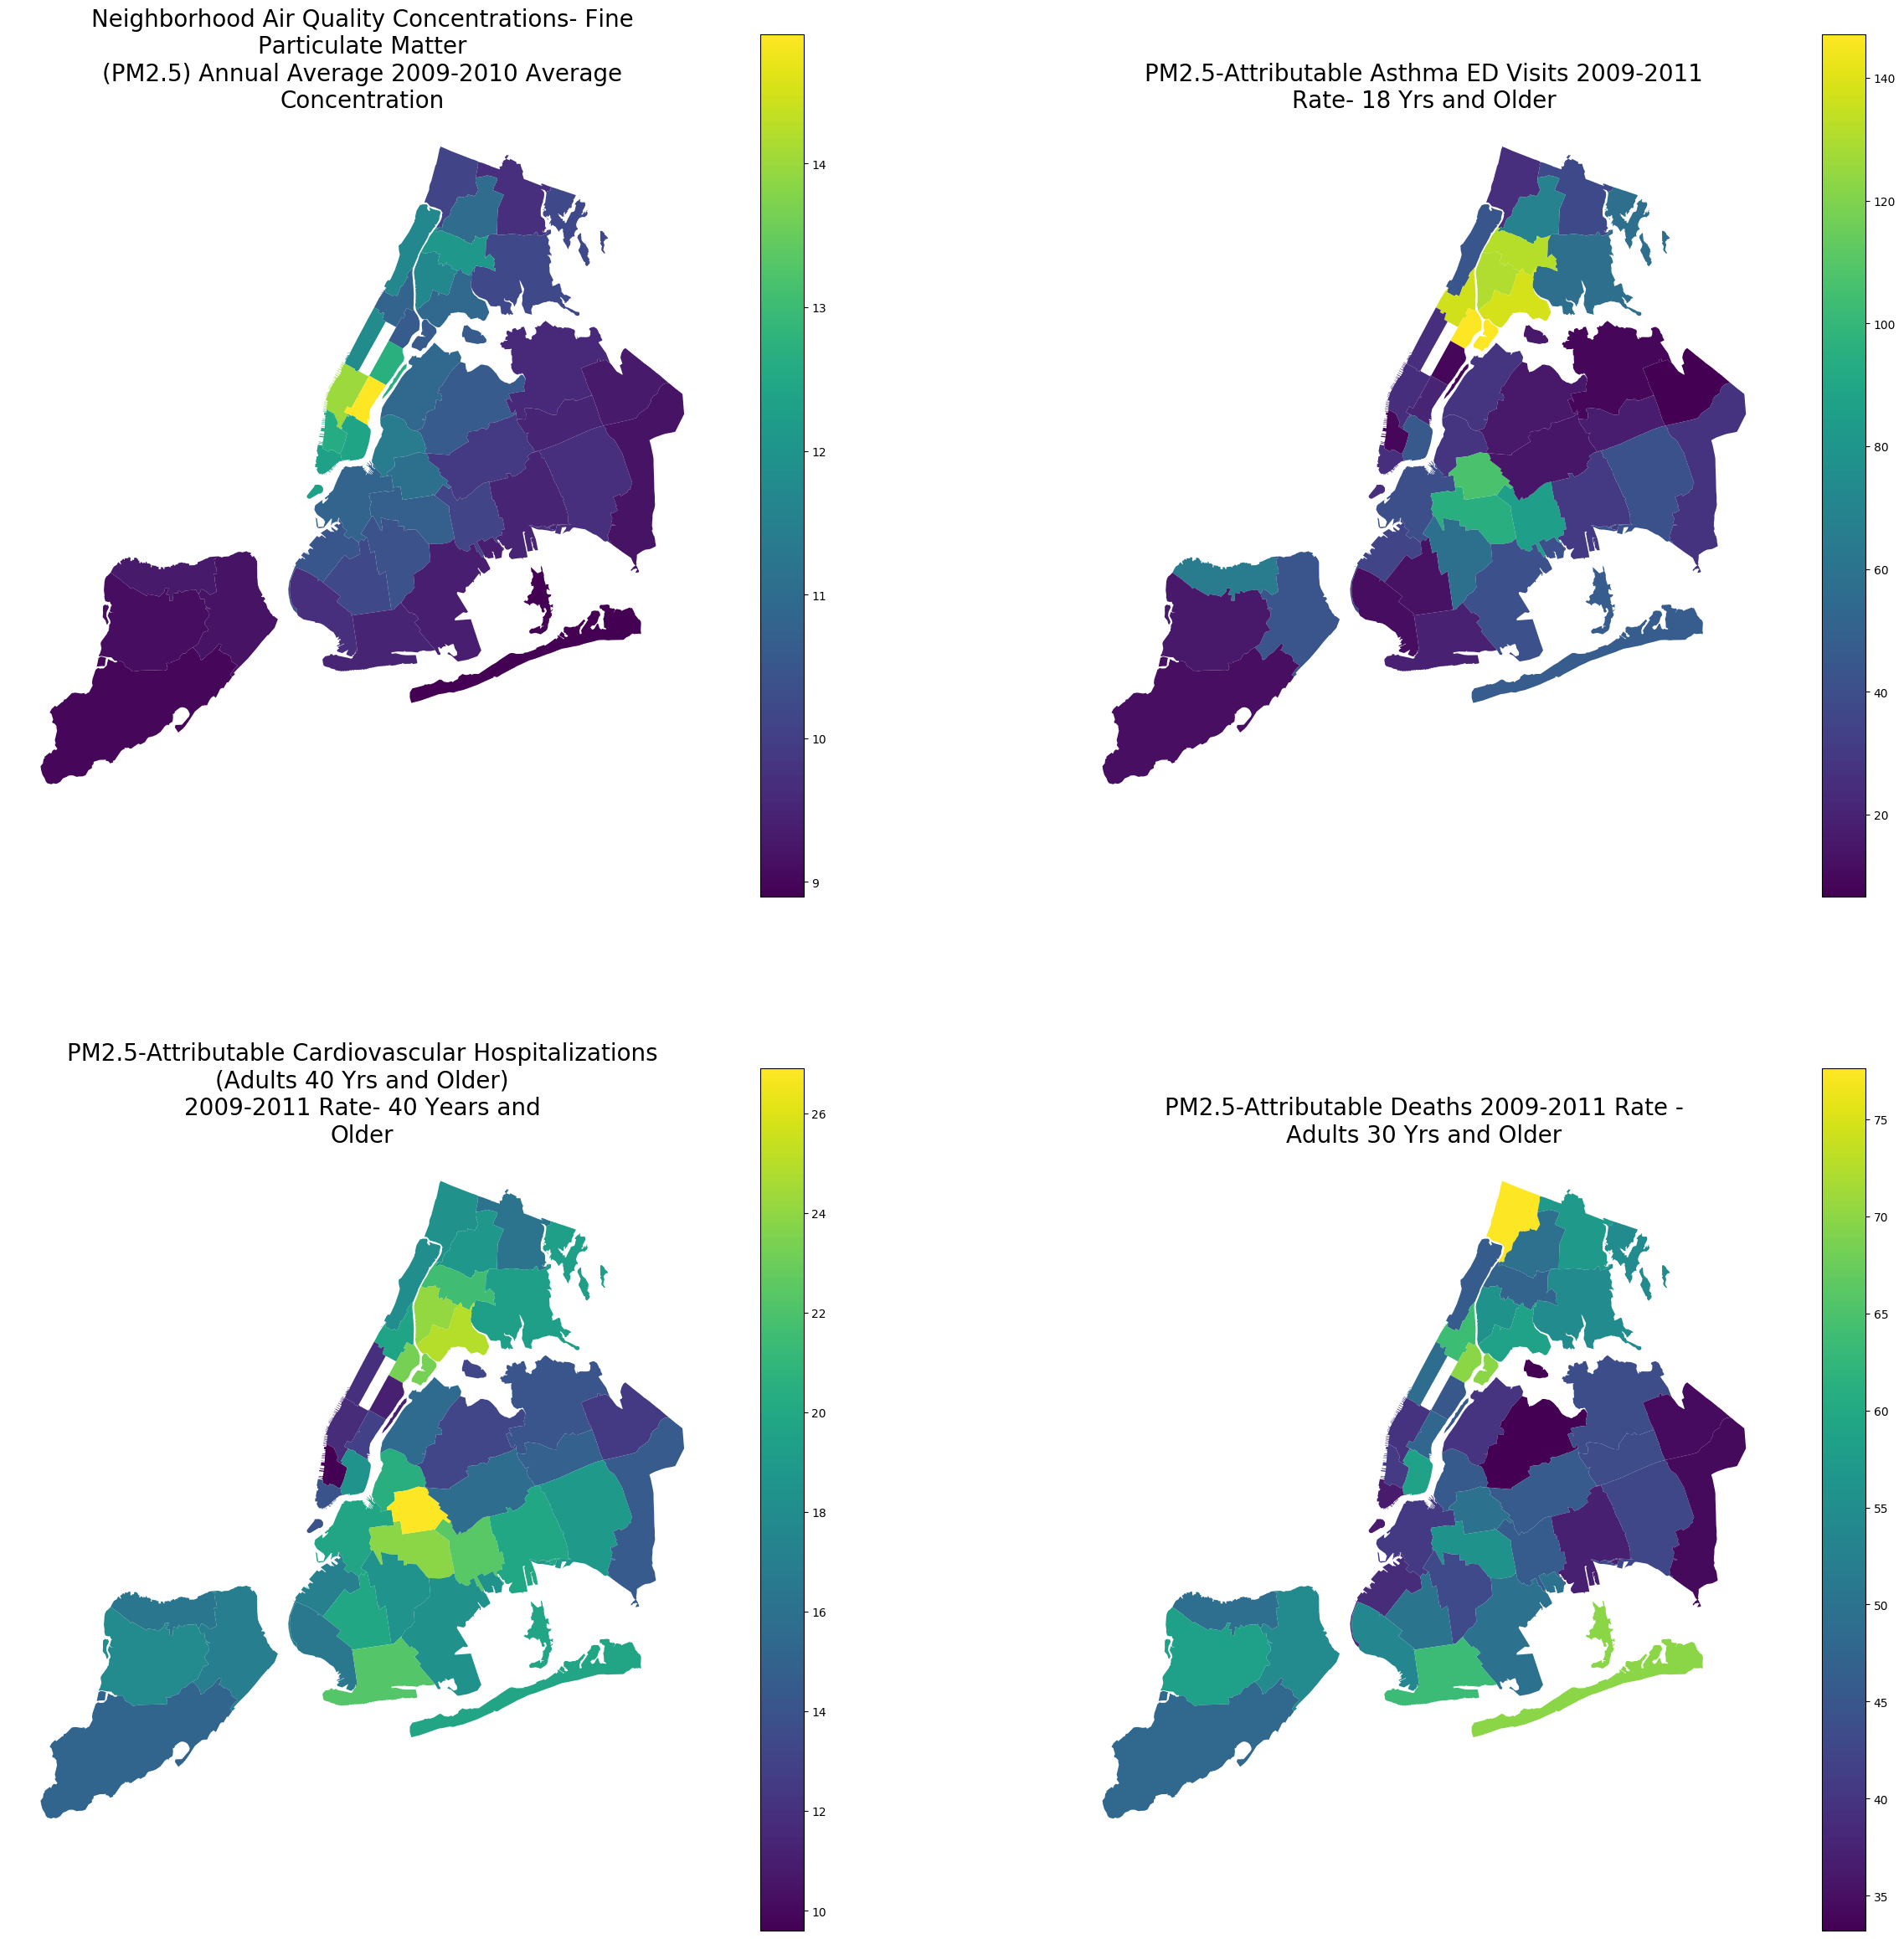

In [21]:
plt.rcParams['axes.titlesize'] = 20
pm25 = [6, 16, 18, 19]

def plot_four(pol):
    f, axs = plt.subplots(figsize = (30, 30), dpi = 100, squeeze = False, nrows = 2, ncols = 2)
    for i, p in enumerate(pol):
        #axs[i][0].axis('off')
        row = i // 2
        col = i % 2
        cm = 'viridis'
        if('Ozone' in pollutants[pol[i]] and 'Concentration' in pollutants[pol[i]]):
            cm = 'viridis_r'
        axs[row][col] = neighborhoods.plot(cmap = cm, ax = axs[row][col], column = pollutants[p], legend = True)
        axs[row][col].set_title(split_title_line(pollutants[pol[i]], max_words = 5))
        axs[row][col].axis('off')
    plt.show()

plot_four(pm25)

On the top left is neighborhood concentrations of PM2.5 particles. The other maps show where people were hospitalized or passed away for any reason attributable to PM2.5. As you can see, there's quite a large disparity between the concentrated sources of the pollutant and the areas most affected by it. 

There could be a variety of reasons for this. Maybe it's because many people in outer boroughs commute to industrial parts of Manhattan to work, and most people go to hospitals near their place of residence. It could also be due to wind patterns, or socioeconomic circumstances limiting access to health services. An even more stark disparity can be seen with Ozone levels. It could also be that these kinds of health problems simply do not happen enough to be statistically significant.

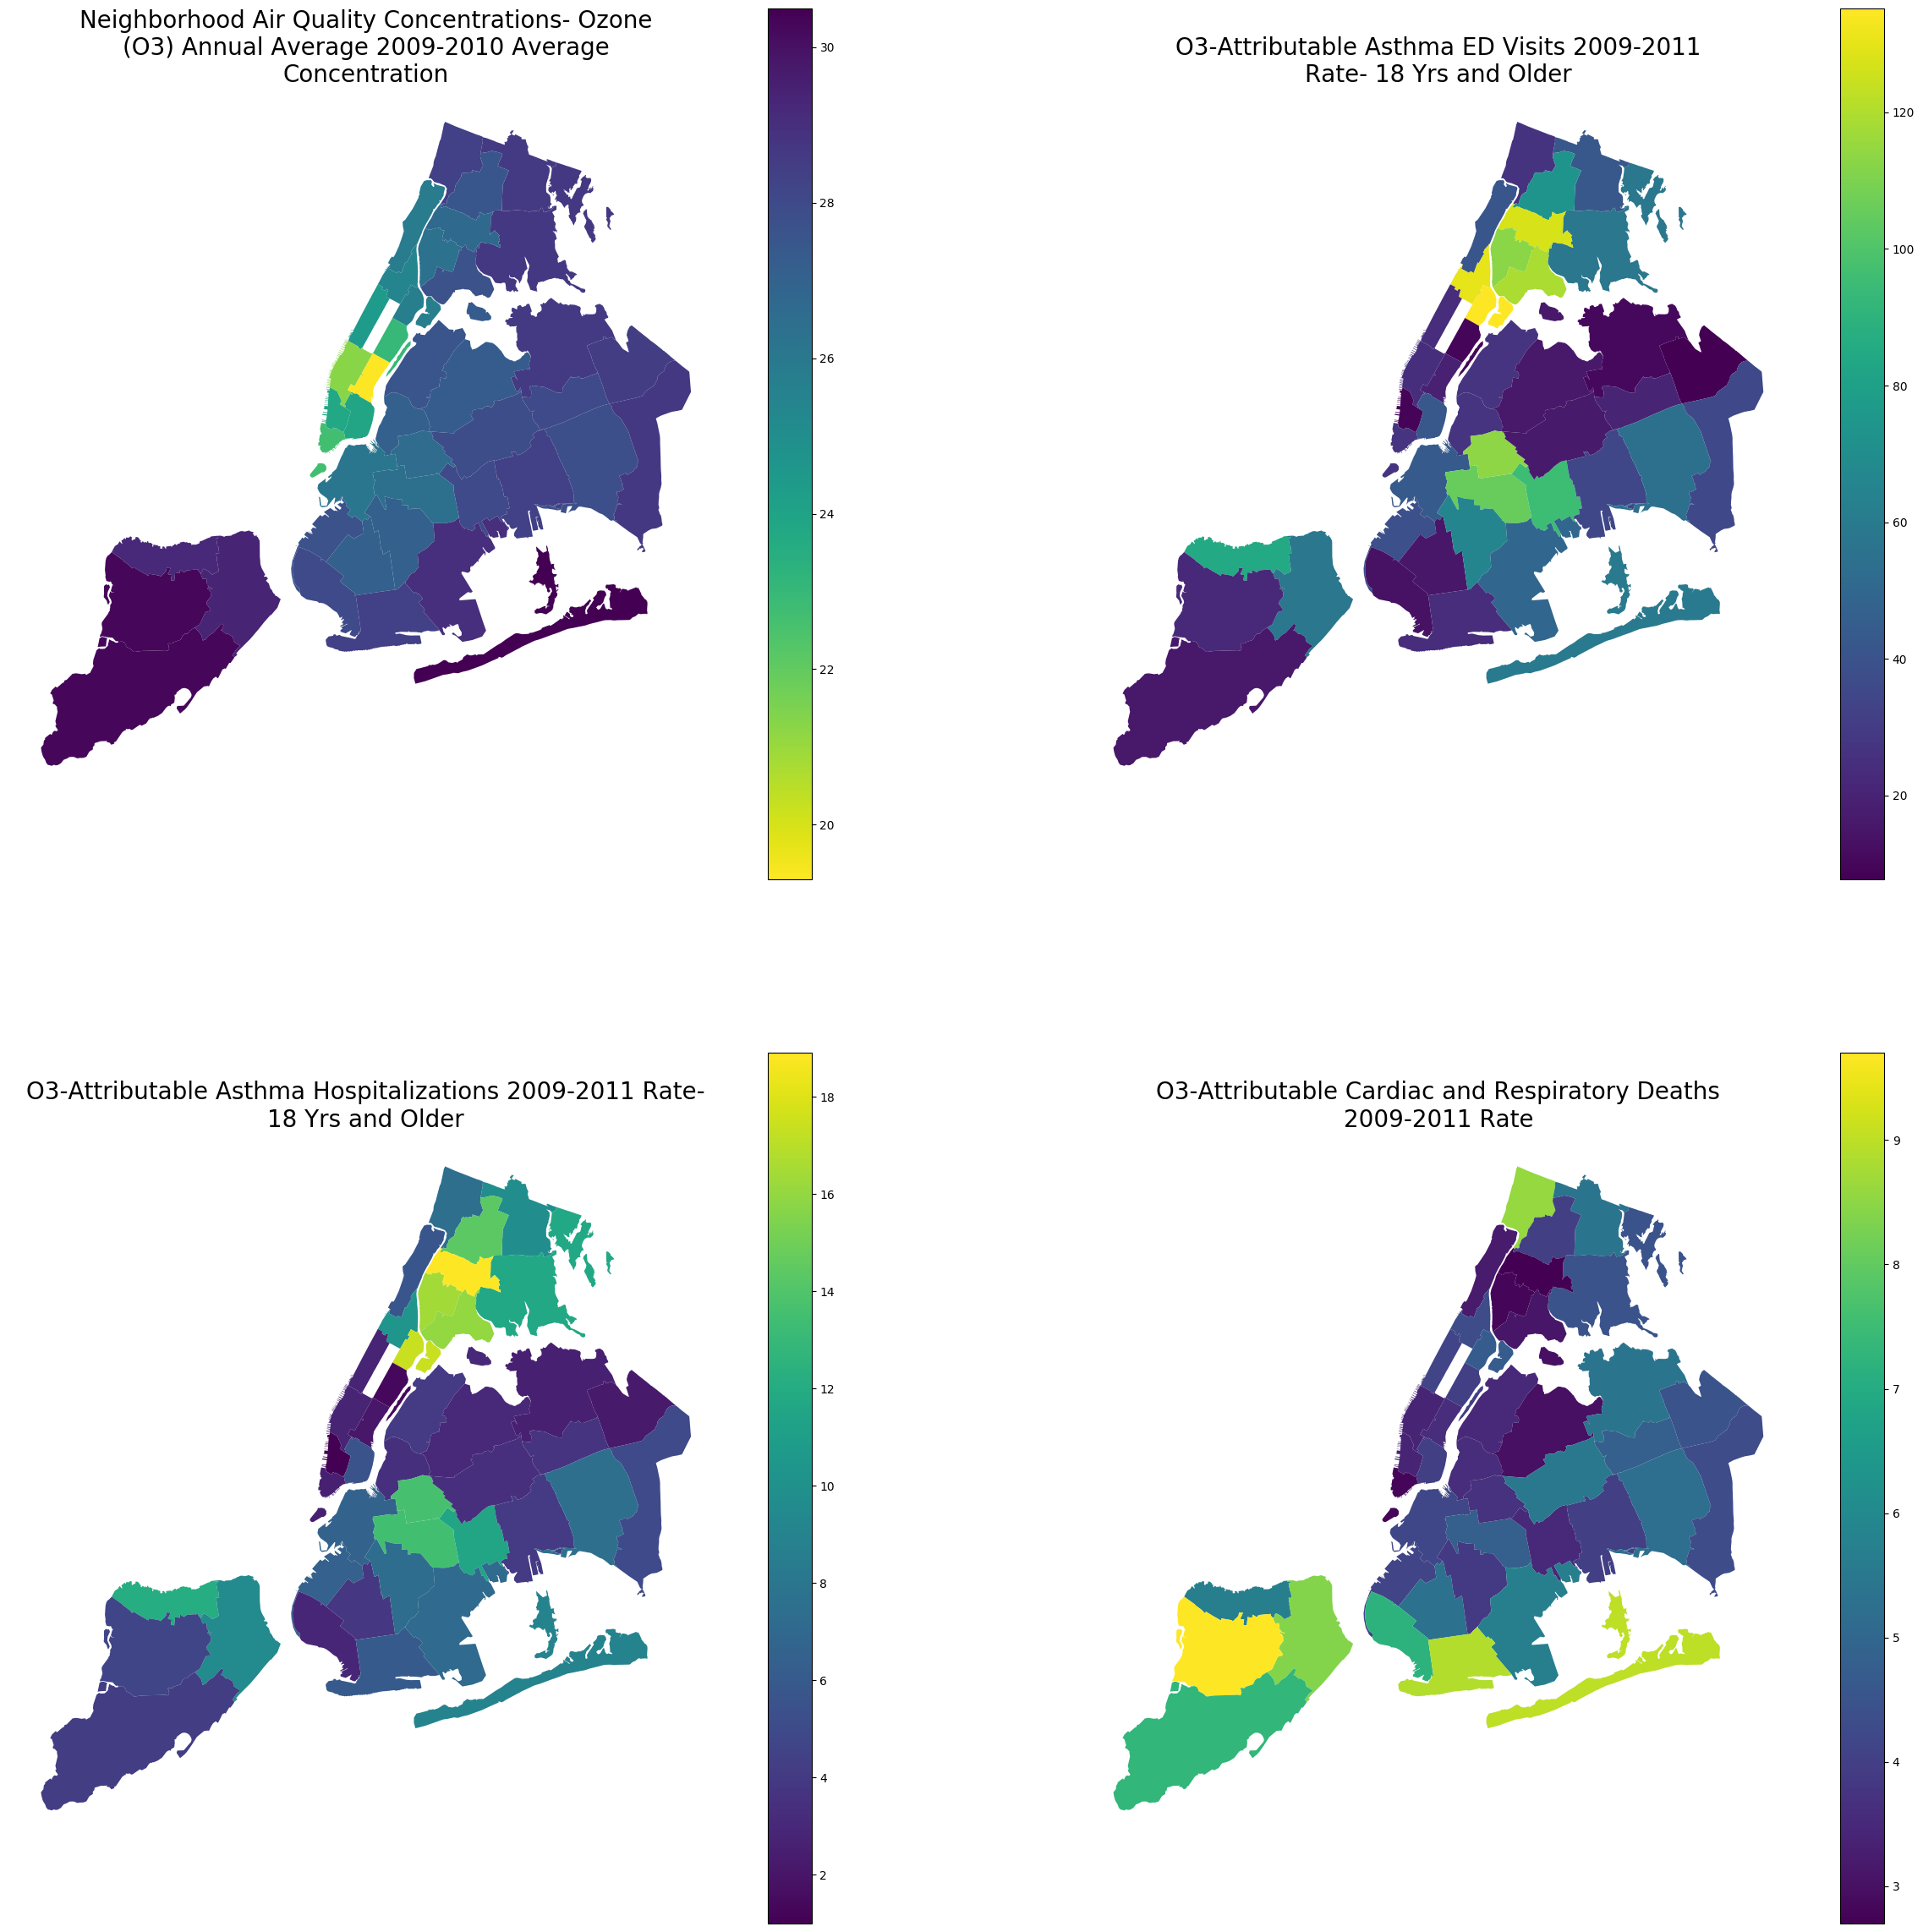

In [22]:
oz = [i for i in range(9, 16, 2)]
plot_four(oz)

### Aggregation and Interactive Map 
Let's put all the pollution information together into an interactive map! Since each map is scaled individually, we need to figure out a way to put all the information together without losing data. We'll split the maps in two - one with the concentration of various pollutants, and one with the health effects.

In [23]:
pollutant_concentration = [pol for pol in pollutants if 'Attributable' not in pol and 'Ozone' not in pol]
health_effects = [pol for pol in pollutants if pol not in pollutant_concentration\
                  and ('Ozone' not in pol and 'O3' not in pol)]

We need to aggregate the data in a way that doesn't drown out the naturally lower ranges of concentration of some pollutants (for example, a 20% concentration of Sulfur Dioxide is a much more significant amount than a 20% concentration of Nitrogen Dioxide). Therefore, we will scale all the pollutants to be some value between 0 and 1, with 0 representing the lowest measured amount of that pollutant and 1 representing the highest. Then, we average all the normalized pollutant values. This is a way to get a clean picture of the data as a whole, but remember that the coloring of the map is *relative*, with colors showing the difference between the most and least polluted neighborhoods of New York, rather than the general amount of pollution in each neighborhood.

In [24]:
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

neighborhoods['avg_health_impact'] = sum(normalize(neighborhoods[column])\
                                         for column in health_effects)/len(health_effects)
neighborhoods['avg_concentration'] = sum([normalize(neighborhoods[column]) \
                                          for column in pollutant_concentration])/len(pollutant_concentration)

### Pollutant Concentration Map
Here is an interactive map of the average concentration that we just calculated.

In [25]:
m = folium.Map([40.730610, -73.935242], tiles = 'CartoDB positron')

m.add_child(folium.Choropleth(
        geo_data = neighborhoods.dropna(),
        name = 'pollution',
        data = neighborhoods.dropna(),
        columns = ['UHF_NEIGH', 'avg_concentration'],
        key_on='feature.properties.UHF_NEIGH',
        fill_color = 'YlOrRd',
        fill_opacity=.9,
        line_opacity=.4,
    )
)
m

### Health Impact Map
Here you can see the areas where health is most disproportionately affected by air pollution. The most pronounced effects are seen near Harlem and The Bronx, as well as Williamsburg/Bushwick. 

In [26]:
m = folium.Map([40.730610, -73.935242], tiles = 'CartoDB positron')

m.add_child(folium.Choropleth(
        geo_data = neighborhoods.dropna(),
        name = 'pollution',
        data = neighborhoods.dropna(),
        columns = ['UHF_NEIGH', 'avg_health_impact'],
        key_on='feature.properties.UHF_NEIGH',
        fill_color = 'BuPu',
        fill_opacity=.9,
        line_opacity=.4,
    )
)
m

### What have we learned?

With these two maps, we can see where there are relatively high levels of some kind of Air Pollutant, and in general which parts of the city feel the health effects of these pollutants the most. We also can see that people in the regions most affected by air pollution are, in general, less socioeconomically well off than the regions producing the pollutants. What happens in one part of New York surely affects the rest, often in ways that aren't obvious to us!

###### Thanks to everybody who helped me with this project!